In [1]:
%config Completer.use_jedi = False


In [1]:
import os
import pandas as pd
import json
import requests
import datetime as dt
import nsepy

In [2]:
INFURA_PROJECT_ID ='20ztuP95w5aQQFMcWK0CSyYQPvU'
INFURA_PROJECT_SECRET ='afe02b4264ed8ac5b67f7872893b0d04'
INFURA_API_ENDPOINT = 'https://ipfs.infura.io:5001/api/v0/'

In [3]:
DATA_PATH = 'datastore/processed/'
instruments  = os.listdir(DATA_PATH)
instruments = ['NIFTY', 'BANKNIFTY', 
               'DLF', 'INFY', 'HINDUNILVR', 
               'HCLTECH', 'TCS', 'SBIN',
               'ASIANPAINT', 'RELIANCE', 'KOTAKBANK',
               'ITC', 'ULTRACEMCO', 'CIPLA', 
               'POWERGRID', 'JSWSTEEL', 'GRASIM', 
               'HINDALCO', 'NMDC', 'VEDL',
               'COALINDIA', 'MPHASIS', 'UPL',
               'GMRINFRA', 'INDHOTEL', 'COFORGE', 
               'CHAMBLFERT', 'AARTIIND', 'LALPATHLAB',
               'PEL', 'STAR']

indices = ['NIFTY', 'BANKNIFTY']
instruments

['NIFTY',
 'BANKNIFTY',
 'DLF',
 'INFY',
 'HINDUNILVR',
 'HCLTECH',
 'TCS',
 'SBIN',
 'ASIANPAINT',
 'RELIANCE',
 'KOTAKBANK',
 'ITC',
 'ULTRACEMCO',
 'CIPLA',
 'POWERGRID',
 'JSWSTEEL',
 'GRASIM',
 'HINDALCO',
 'NMDC',
 'VEDL',
 'COALINDIA',
 'MPHASIS',
 'UPL',
 'GMRINFRA',
 'INDHOTEL',
 'COFORGE',
 'CHAMBLFERT',
 'AARTIIND',
 'LALPATHLAB',
 'PEL',
 'STAR']

In [4]:
today = dt.date.today()

data_dict = {}
for underlying in instruments:
    # flag
    is_index = underlying in indices
    # Load saved data from file
    csv_path = os.path.join(DATA_PATH, underlying,underlying+'.csv')
    
    if os.path.exists(csv_path):
        data_df = pd.read_csv(csv_path, parse_dates=['Date'], index_col='Date')
        last_updated = data_df.index.max().date()
        data_df = data_df.drop_duplicates()
    else:
        # Make the idrectory and download the data
        try:
            os.mkdir(os.path.join(DATA_PATH, underlying))
        except FileExistsError:
            pass
        # Download data for the last 3 years if not present
        data_df = nsepy.get_history(underlying, start=today - dt.timedelta(365*3), end=today, index=is_index)
        
        data_df.to_csv(csv_path)
        last_updated = data_df.index.max()
    
    

    # Check whether data is out of date and update if necessary
    if today > (last_updated+dt.timedelta(days=2)):
        update_df = nsepy.get_history(underlying, start=last_updated, end=today, index=is_index)
        if len(update_df) > 0:
            data_df = pd.concat([data_df, update_df])
            data_df = data_df.drop_duplicates()
            data_df.to_csv(csv_path)
    # Save each instrument to ipfs
    files = {underlying: data_df.reset_index().to_json(orient='records')}
    response = requests.post(INFURA_API_ENDPOINT+'add', files=files, 
                             params={'pin':True}, 
                             auth=(INFURA_PROJECT_ID,INFURA_PROJECT_SECRET))
    data_hash = response.json()['Hash']
    data_dict[underlying] = data_hash

# Save their location into ipfs
response = requests.post(INFURA_API_ENDPOINT+'add', files={'dataroot':json.dumps(data_dict)}, 
                         params={'pin':True}, 
                         auth=(INFURA_PROJECT_ID,INFURA_PROJECT_SECRET))

data_root_hash = response.json()['Hash']

# Save the data root hash
with open('datastore/nse.dataroot', mode='w+') as dataroot:
    dataroot.write(data_root_hash)

In [5]:
data_root_hash

'Qma38kW9X6VvJv7GewBE6pZ7NR2x9U9pALuTiXBRWAok8D'

In [10]:
# PROVIDER_URL = 'https://ipfs.infura.io/ipfs/'
PROVIDER_URL = 'https://cloudflare-ipfs.com/ipfs/'
with open('datastore/nse.dataroot', mode='r') as f:
    ipfs_url = PROVIDER_URL+f.readline()
    print(f'reading from {ipfs_url}')
    data_dict = requests.get(ipfs_url).json()
    data_hash = data_dict['NIFTY']
    underlying_df = pd.read_json(PROVIDER_URL+data_hash)
     

reading from https://cloudflare-ipfs.com/ipfs/QmSTce8M6vyQR93cV7CyLG8dgwVj1P914jx1b69xDcvujo


In [ ]:
list(data_dict.keys())

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
underlying_df = pd.read_json(PROVIDER_URL+data_dict['NIFTY'])

In [114]:
underlying_df = underlying_df.set_index('Date')

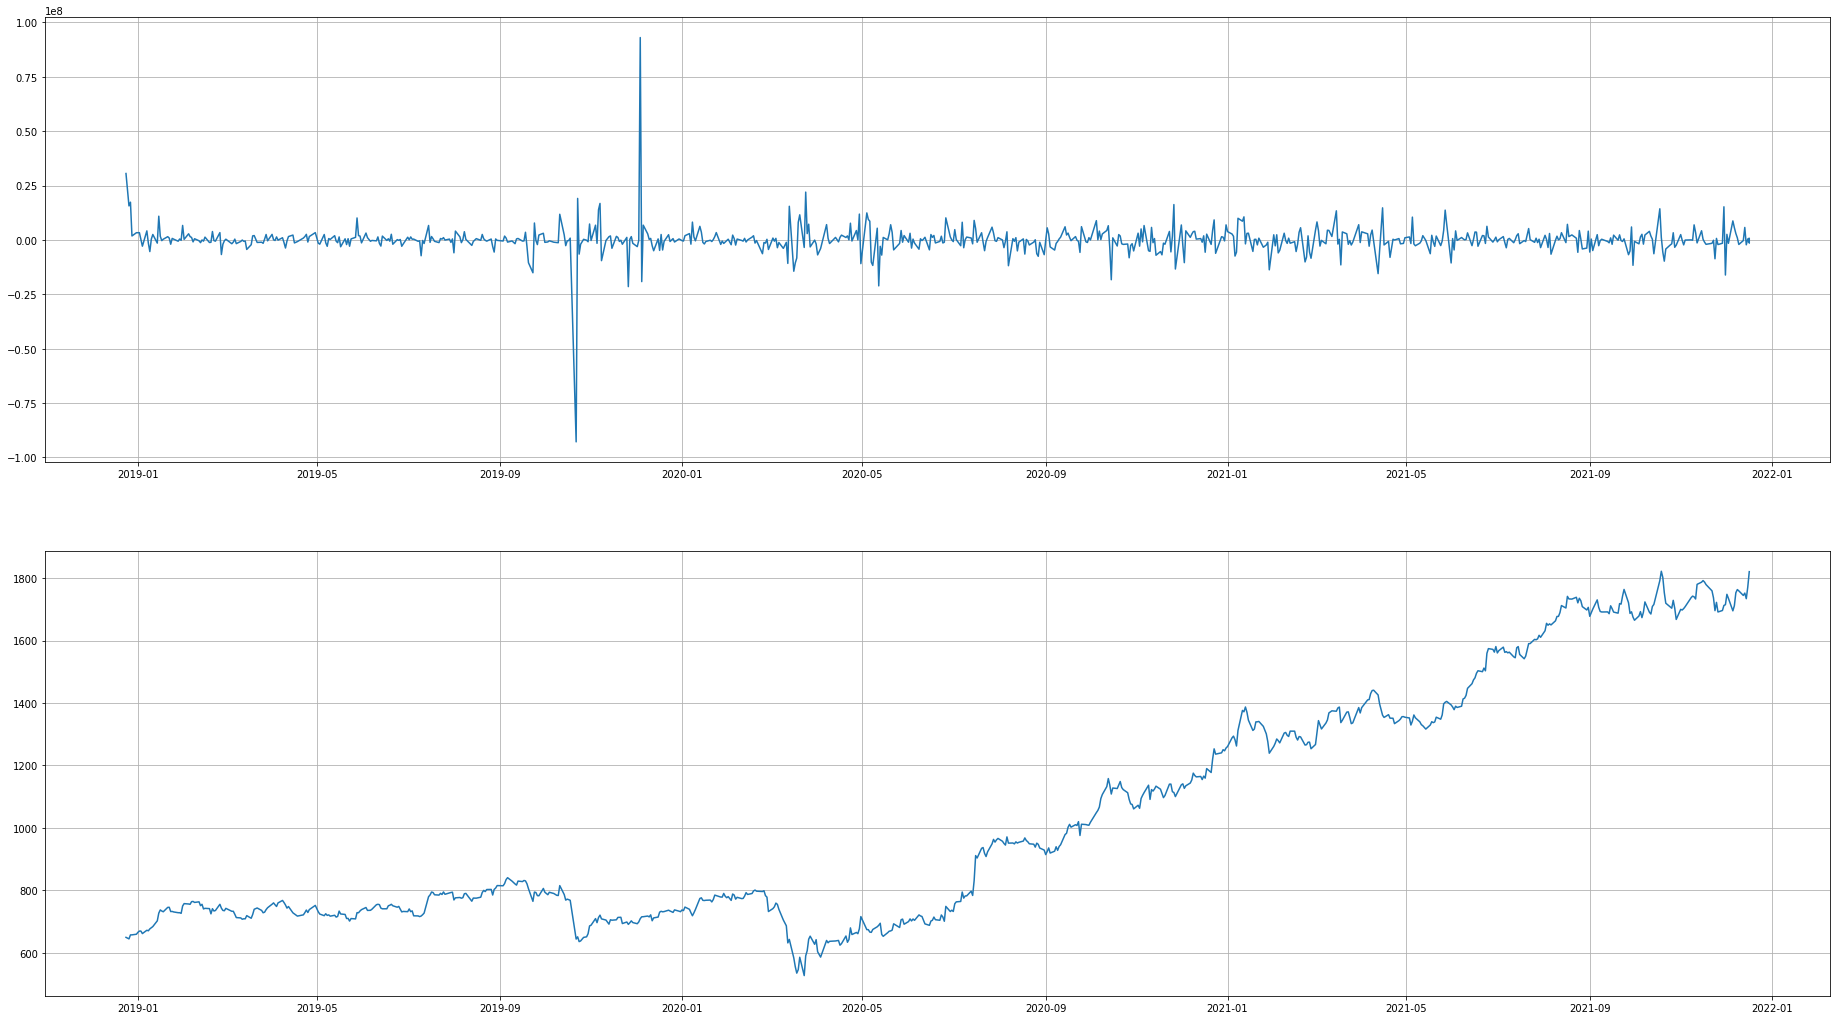

In [130]:
fig = plt.figure(figsize=(32,18))
ax = fig.add_subplot(211)
ax.plot((underlying_df['Deliverable Volume']*(underlying_df['Close']-underlying_df['Open'])).rolling(30, min_periods=1).mean().diff())
# ax.plot((underlying_df['Deliverable Volume']*(underlying_df['Close']-underlying_df['Open']))[8:])

ax.grid()
ax = fig.add_subplot(212)
ax.plot(underlying_df['Close'][1:])
ax.grid()

In [6]:
response = requests.post(INFURA_API_ENDPOINT+'cat', 
                         params={'arg':'QmYcxeeDVJzaHGwBxJNnZ66hbr9rV8BYMbmBHZxsUfWabH'},
                         auth=(INFURA_PROJECT_ID,INFURA_PROJECT_SECRET))

In [7]:
response.content

b'{"BANKNIFTY": "Qmc5Xhtf1fBUV9pQucgYb9STRQNYgKiZmjFCnq3jRgvDBq", "NIFTY": "QmZTs29KSaemqxJK71AbCcyivrQFw51Pc7xX9ktM264X2r"}'

In [8]:
response = requests.post(INFURA_API_ENDPOINT+'cat', 
                         params={'arg':'Qmc5Xhtf1fBUV9pQucgYb9STRQNYgKiZmjFCnq3jRgvDBq'},
                         auth=(INFURA_PROJECT_ID,INFURA_PROJECT_SECRET))
# response.json()['Hash']

In [9]:
(response)

<Response [200]>

In [24]:
response.json()

[{'Date': 1514851200000,
  'Close': 25338.25,
  'High': 25425.5,
  'Low': 25232.8,
  'Open': 25382.2,
  'Turnover': 22703600000.0,
  'Volume': 72033811.0},
 {'Date': 1514937600000,
  'Close': 25318.6,
  'High': 25454.9,
  'Low': 25300.9,
  'Open': 25425.75,
  'Turnover': 19582100000.0,
  'Volume': 59730356.0},
 {'Date': 1515024000000,
  'Close': 25462.6,
  'High': 25490.35,
  'Low': 25310.3,
  'Open': 25367.65,
  'Turnover': 26466200000.0,
  'Volume': 105995860.0},
 {'Date': 1515110400000,
  'Close': 25601.85,
  'High': 25643.35,
  'Low': 25499.55,
  'Open': 25524.45,
  'Turnover': 31880800000.0,
  'Volume': 123622612.0},
 {'Date': 1515369600000,
  'Close': 25676.1,
  'High': 25771.5,
  'Low': 25643.8,
  'Open': 25690.25,
  'Turnover': 27275300000.000004,
  'Volume': 127527935.0},
 {'Date': 1515456000000,
  'Close': 25703.8,
  'High': 25803.8,
  'Low': 25617.25,
  'Open': 25727.95,
  'Turnover': 26171300000.0,
  'Volume': 101820385.0},
 {'Date': 1515542400000,
  'Close': 25617.3,
  'Hi

In [10]:
files = {
        underlying: data_df.to_json(orient='records')
        }

In [11]:
response = requests.post(INFURA_API_ENDPOINT+'add', files=files, params={'pin':True}, auth=(INFURA_PROJECT_ID,INFURA_PROJECT_SECRET))

In [12]:
data_hash = response.json()['Hash']

In [13]:
data_hash

'QmavCZzAxdMhBCEdb5urDzzhamfUxPQCTCqSWu8NgqL8rT'

In [ ]:
# Get list of providers
providers = requests.get('https://raw.githubusercontent.com/ipfs/public-gateway-checker/master/gateways.json').json()

In [ ]:
# Remove :hash templating
providers = list(map(lambda x: x[:-5], providers))

In [ ]:
providers[:20]

In [61]:
provider_url = 'https://ipfs.infura.io/ipfs/'

In [102]:
data_hash

'QmSYmkseRG2rw2yFZPWAid7H5S6jqVnvowTA1bZFDcJ9NG'

In [88]:
#data_dict = {}

In [103]:
data_dict[underlying]= data_hash

In [104]:
data_dict

{'BANKNIFTY': 'QmPq8c7PwDoezFZqWouJ8RjguHBo3aFye7FVWWCsAdpioC',
 'NIFTY': 'QmSYmkseRG2rw2yFZPWAid7H5S6jqVnvowTA1bZFDcJ9NG'}

In [81]:
provider_url+data_hash

'https://ipfs.infura.io/ipfs/QmPq8c7PwDoezFZqWouJ8RjguHBo3aFye7FVWWCsAdpioC'

In [82]:
underlying_df = pd.read_json(provider_url+data_hash)

In [85]:
underlying_df = underlying_df.set_index('Date')

,Close,High,Low,Open,Turnover,Volume
Date,,,,,,
2018-01-02,25338.25,25425.50,25232.80,25382.20,2.270360e+10,72033811.0
2018-01-03,25318.60,25454.90,25300.90,25425.75,1.958210e+10,59730356.0
2018-01-04,25462.60,25490.35,25310.30,25367.65,2.646620e+10,105995860.0
2018-01-05,25601.85,25643.35,25499.55,25524.45,3.188080e+10,123622612.0
2018-01-08,25676.10,25771.50,25643.80,25690.25,2.727530e+10,127527935.0
...,...,...,...,...,...,...
2021-11-10,39023.25,39220.30,38873.80,39206.20,5.776380e+10,167942059.0
2021-11-11,38560.20,38929.95,38346.05,38913.05,4.676680e+10,146046747.0
2021-11-12,38733.35,38822.85,38467.80,38707.15,5.412250e+10,136008185.0
